In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
try:
  import shap
  from xgboost import XGBClassifier, plot_importance
  print("Libraries imported")
except:
  !pip install shap xgboost
  from xgboost import XGBClassifier, plot_importance
  import shap
  print("Shap installed")



Libraries imported


In [17]:
import zipfile
import os

# Define the path to your zip file and the directory where it will be extracted
zip_file_path = 'archive_4.zip'
extract_to_directory = 'dataset'

# Ensure the destination directory exists
os.makedirs(extract_to_directory, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print(f"Extraction completed. Files extracted to: {extract_to_directory}")


Extraction completed. Files extracted to: dataset


In [18]:
# === Load Training Data ===
train_label = pd.read_csv('dataset/Train-1542865627584.csv')  # Provider, PotentialFraud
train_beneficiary = pd.read_csv('dataset/Train_Beneficiarydata-1542865627584.csv')
train_inpatient = pd.read_csv('dataset/Train_Inpatientdata-1542865627584.csv')
train_outpatient = pd.read_csv('dataset/Train_Outpatientdata-1542865627584.csv')

# Combine inpatient and outpatient records
train_claims = pd.concat([train_inpatient, train_outpatient], ignore_index=True)

# Merge claims with beneficiary information
train_merged = train_claims.merge(train_beneficiary, on='BeneID', how='left')

# Merge with the label using 'Provider'
train_merged = train_merged.merge(train_label, on='Provider', how='left')

# === Load Testing Data ===
test_main = pd.read_csv('dataset/Test-1542969243754.csv')  # Provider only, no labels
test_beneficiary = pd.read_csv('dataset/Test_Beneficiarydata-1542969243754.csv')
test_inpatient = pd.read_csv('dataset/Test_Inpatientdata-1542969243754.csv')
test_outpatient = pd.read_csv('dataset/Test_Outpatientdata-1542969243754.csv')

# Combine inpatient and outpatient test records
test_claims = pd.concat([test_inpatient, test_outpatient], ignore_index=True)

# Merge with beneficiary information
test_merged = test_claims.merge(test_beneficiary, on='BeneID', how='left')

# Merge with the test provider metadata (for completeness)
test_merged = test_merged.merge(test_main, on='Provider', how='left')

# === Export to CSV ===
train_merged.to_csv('train_combined.csv', index=False)
test_merged.to_csv('test_combined.csv', index=False)

print("✅ Merging completed: 'train_combined.csv' and 'test_combined.csv' generated.")


✅ Merging completed: 'train_combined.csv' and 'test_combined.csv' generated.


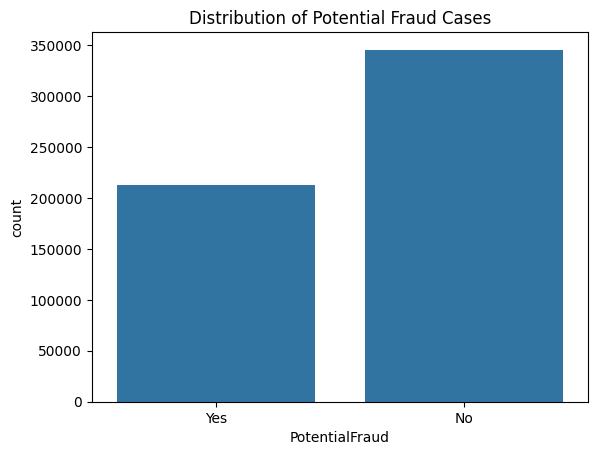

In [19]:


df = pd.read_csv('train_combined.csv', low_memory = False)
sns.countplot(data=df, x='PotentialFraud')
plt.title('Distribution of Potential Fraud Cases')
plt.show()


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 55 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   AdmissionDt                      40474 non-null   object 
 10  ClmAdmitDiagnosisCode            145899 non-null  object 
 11  DeductibleAmtPaid                557312 non-null  float64
 12  Di

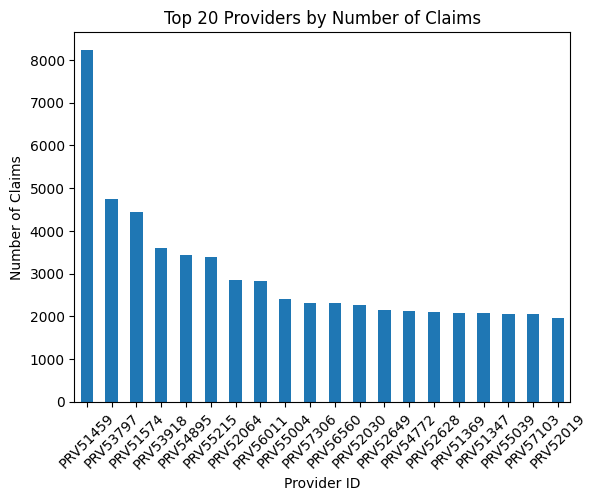

In [21]:
claims_per_provider = df['Provider'].value_counts().head(20)
claims_per_provider.plot(kind='bar')
plt.title('Top 20 Providers by Number of Claims')
plt.ylabel('Number of Claims')
plt.xlabel('Provider ID')
plt.xticks(rotation=45)
plt.show()


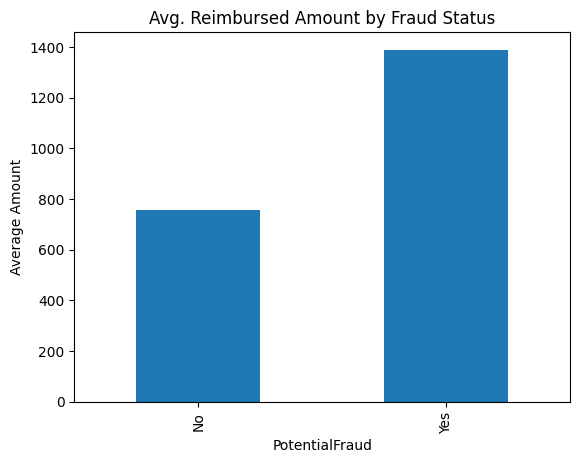

In [22]:
df.groupby('PotentialFraud')['InscClaimAmtReimbursed'].mean().plot(kind='bar')
plt.title('Avg. Reimbursed Amount by Fraud Status')
plt.ylabel('Average Amount')
plt.show()


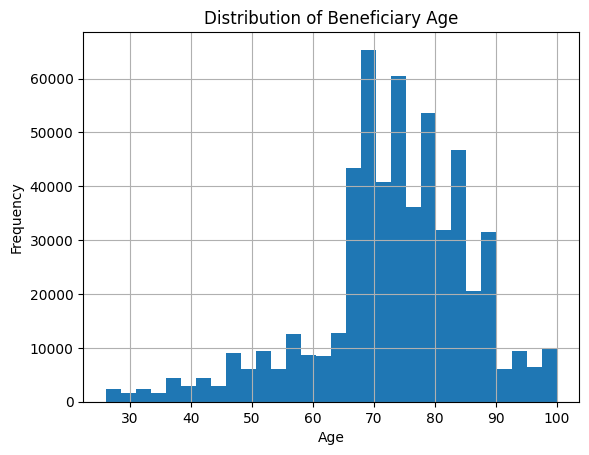

In [23]:
df['DOB1'] = pd.to_datetime(df['DOB'], errors='coerce')
df['Age'] = 2009 - df['DOB1'].dt.year  # Assuming data is from 2009
df.drop('DOB1', axis=1, inplace=True)
df['Age'].hist(bins=30)
plt.title('Distribution of Beneficiary Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


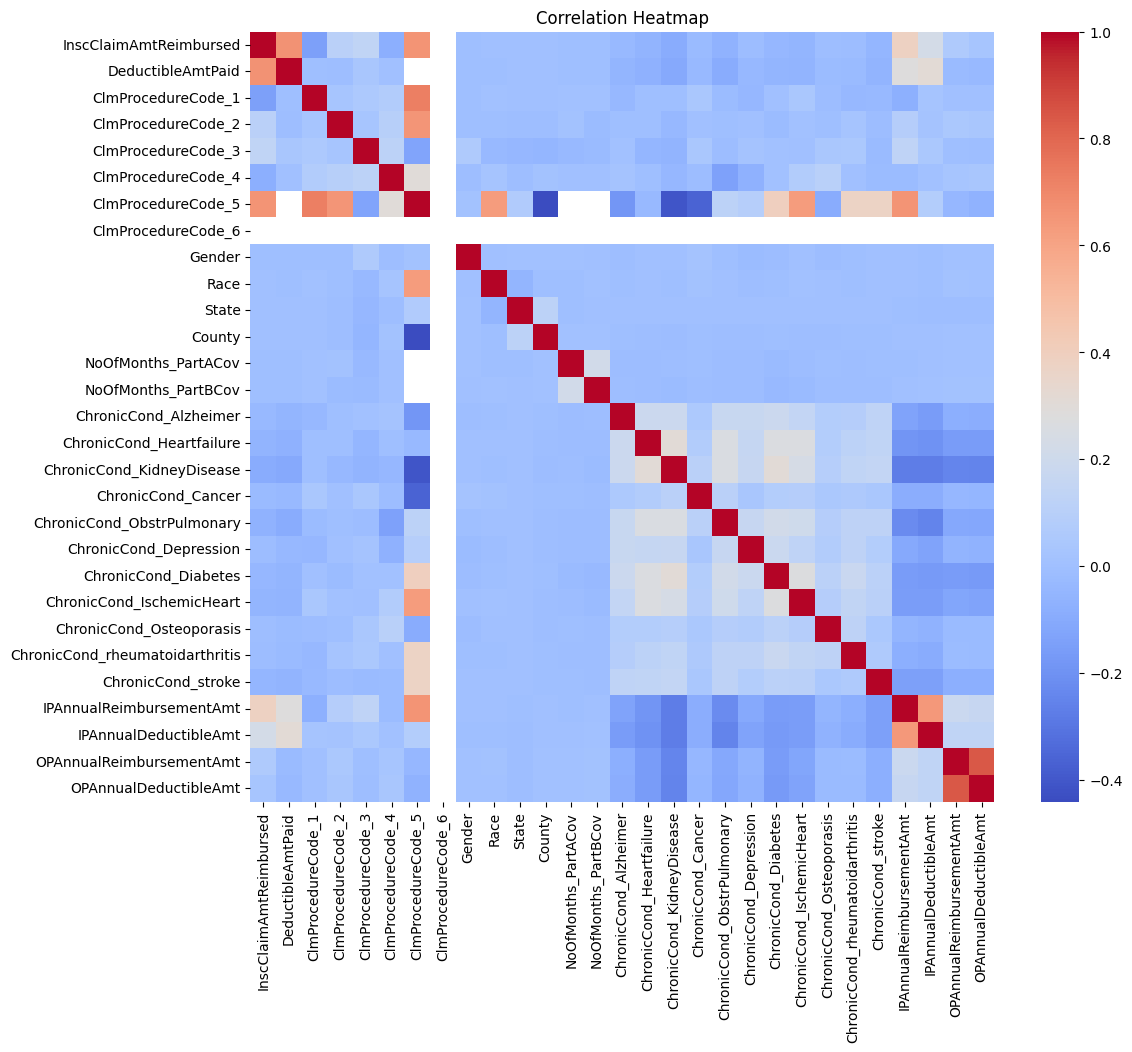

In [24]:
corr = df.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()


In [25]:
# === Preprocess ===
# Drop columns that are identifiers
df = df.drop(columns=['BeneID', 'ClaimID'])

# Handle missing values
df = df.fillna(0)

# Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = df.drop('PotentialFraud', axis=1)
y = df['PotentialFraud']

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === Model & Hyperparameter Tuning ===
xgb = XGBClassifier(eval_metric='logloss')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

# === Evaluation ===
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}

Confusion Matrix:
 [[65508  3575]
 [ 7324 35236]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92     69083
           1       0.91      0.83      0.87     42560

    accuracy                           0.90    111643
   macro avg       0.90      0.89      0.89    111643
weighted avg       0.90      0.90      0.90    111643



<Figure size 1200x800 with 0 Axes>

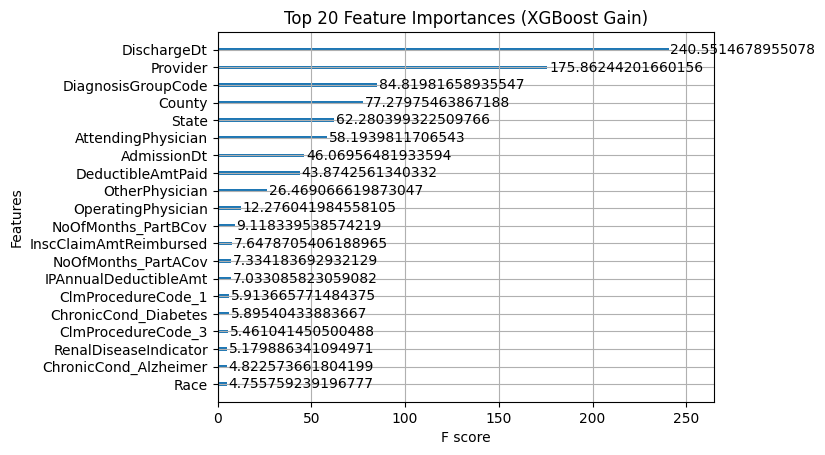

In [26]:
# Plot top 20 features based on XGBoost's built-in importance score
plt.figure(figsize=(12, 8))
plot_importance(best_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (XGBoost Gain)")
plt.show()


In [27]:
!pip install shap

100%|===================| 111627/111643 [13:05<00:00]       

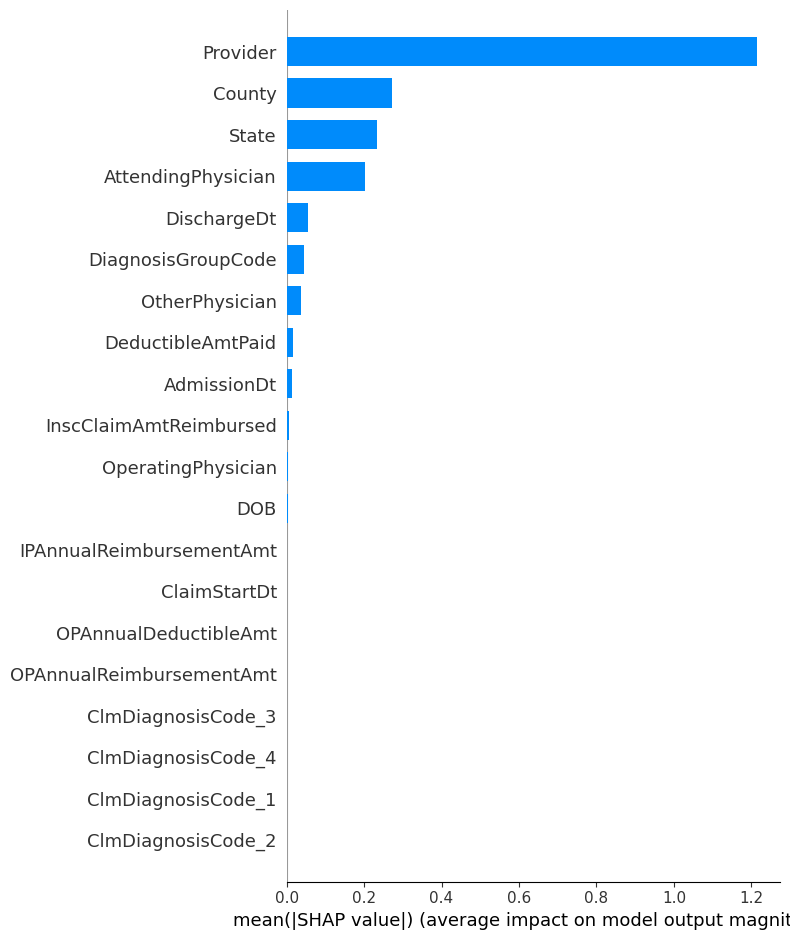

In [28]:
# Create the SHAP explainer
explainer = shap.Explainer(best_model, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Summary plot (global interpretation)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)
